Using device: cuda
Loading evaluation model: protectai/deberta-v3-base-prompt-injection-v2...
Loading CodeAlpaca-20k as SAFE dataset...
SAFE samples (CodeAlpaca): 20022
Loading CyberNative/Code_Vulnerability_Security_DPO as POISON dataset...
POISON samples (CyberNative vulnerable): 4656
Loading zrmarine/Durinn_Hacktoberfest_Retrospective as DURINN dataset...


Repo card metadata block was not found. Setting CardData to empty.


DURINN samples: 52

Scoring SAFE (CodeAlpaca) samples...
  Scored 20022/20022
Scoring POISON (CyberNative vulnerable) samples...
  Scored 4656/4656
Scoring DURINN samples...
  Scored 52/52

--- SAFE raw probs ---
Mean:    0.002910
Median:  0.000004
90th %:  0.000189
95th %:  0.001013
Max:     1.000000

--- POISON raw probs ---
Mean:    0.012601
Median:  0.000002
90th %:  0.000010
95th %:  0.000018
Max:     0.999993

--- DURINN raw probs ---
Mean:    0.000015
Median:  0.000004
90th %:  0.000038
95th %:  0.000084
Max:     0.000102

Learning temperature on SAFE+POISON...
[Temp] step 1/400, loss=2.3821, T=1.0100
[Temp] step 100/400, loss=1.3418, T=1.7863
[Temp] step 200/400, loss=1.0476, T=2.3007
[Temp] step 300/400, loss=0.8980, T=2.7111
[Temp] step 400/400, loss=0.8060, T=3.0609
Learned temperature T*: 3.0609

--- SAFE calibrated probs ---
Mean:    0.029929
Median:  0.016867
90th %:  0.057241
95th %:  0.095147
Max:     0.992110

--- POISON calibrated probs ---
Mean:    0.027046
Median:  

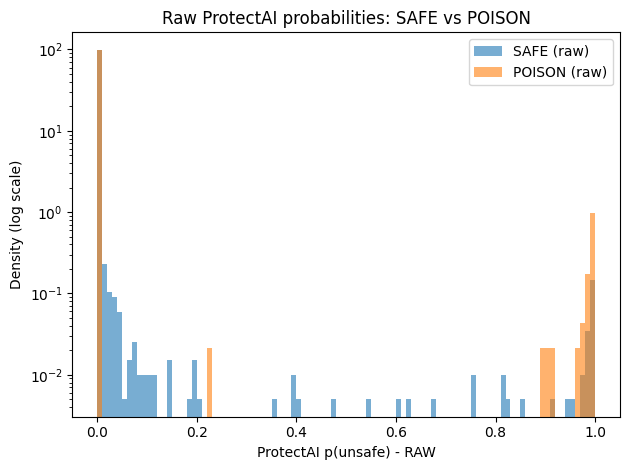

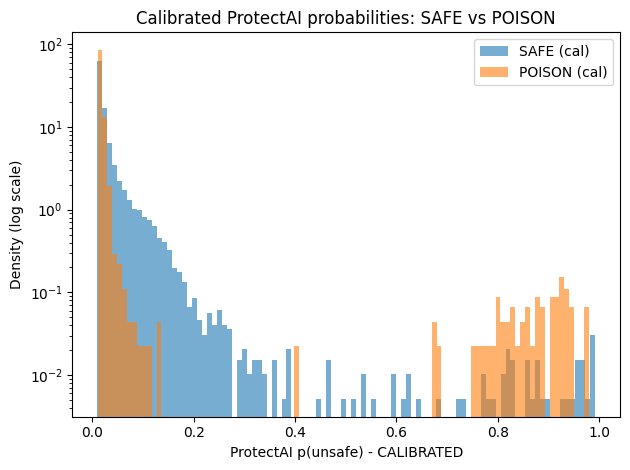

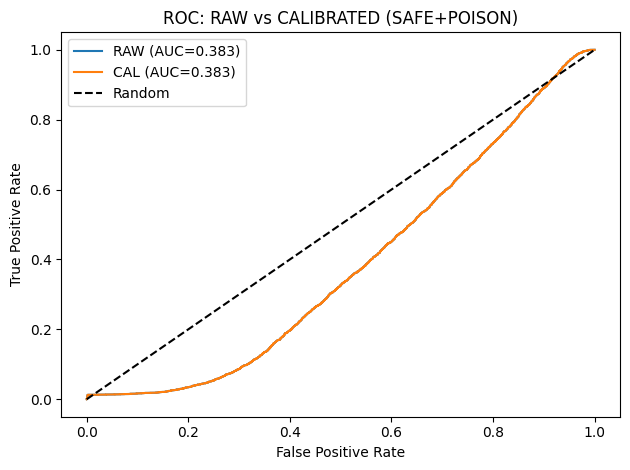

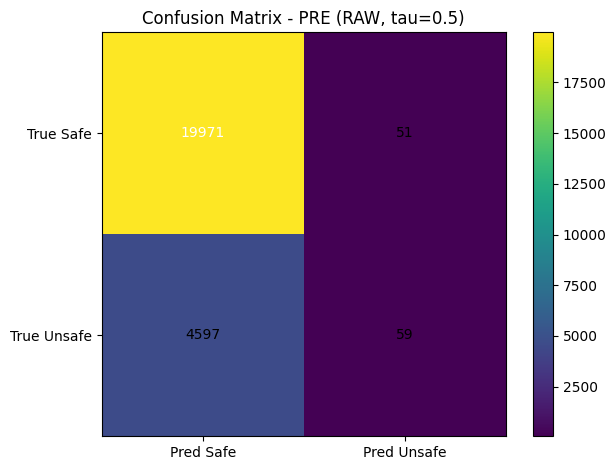

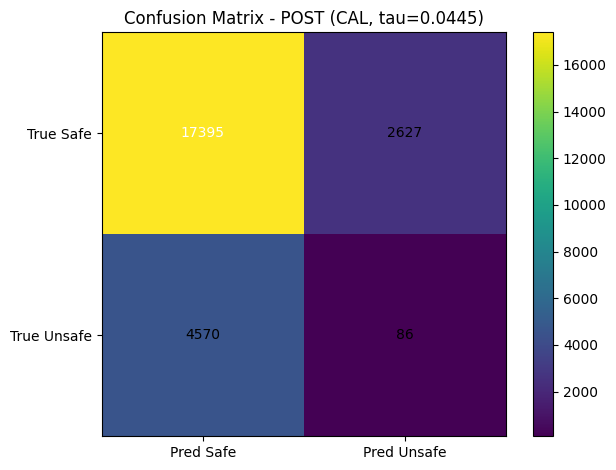


Done.


In [ ]:
#!/usr/bin/env python
"""
Reproduce ProtectAI calibration experiment with visualizations.

Safe data:
  - sahil2801/CodeAlpaca-20k

Poison data:
  - CyberNative/Code_Vulnerability_Security_DPO (vulnerable 'rejected')

Calibration data:
  - zrmarine/Durinn_Hacktoberfest_Retrospective

Judge model:
  - protectai/deberta-v3-base-prompt-injection-v2

What this script does:
  1. Load datasets and build text fields.
  2. Score SAFE, POISON, DURINN with ProtectAI (logits + raw probs).
  3. Learn temperature on SAFE+POISON.
  4. Use DURINN to define calibrated threshold (percentile).
  5. Compare PRE (raw, tau_naive) vs POST (calibrated, tau_cal):
     - Confusion matrices
     - Recall, precision, FPR, etc.
  6. Identify POISON examples missed by naive but caught by calibrated.
  7. Plot:
     - Histograms of raw vs calibrated probs for SAFE vs POISON.
     - ROC curves for raw vs calibrated.
     - Confusion-matrix heatmaps for pre vs post.
"""

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

# -------------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------------
MODEL_NAME = "protectai/deberta-v3-base-prompt-injection-v2"

TAU_NAIVE = 0.5                 # typical classifier default
DURINN_PERCENTILE = 95          # e.g. 95th percentile of Durinn calibrated probs

MAX_LEN = 512
BATCH_SIZE = 16
TEMP_LR = 0.01
TEMP_ITERS = 400

# Optional subsampling for speed (set to None to use full dataset)
SAFE_MAX = None     # e.g. 5000
POISON_MAX = None   # e.g. 3000
DURINN_MAX = None   # probably fine as-is

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# -------------------------------------------------------------------
# HELPERS
# -------------------------------------------------------------------
@torch.no_grad()
def get_logits_for_texts(model, tokenizer, texts):
    """
    texts: list[str]
    returns: np.array [N, 2] logits
    """
    all_logits = []
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i : i + BATCH_SIZE]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_LEN,
            padding=True,
        ).to(device)

        outputs = model(**inputs)
        logits = outputs.logits  # [B, 2]
        all_logits.append(logits.cpu())

        print(f"  Scored {min(i + BATCH_SIZE, len(texts))}/{len(texts)}", end="\r")
    print()
    return torch.cat(all_logits, dim=0).numpy()


def probs_from_logits(logits):
    """Return p(class=1) from logits [N, 2]"""
    exps = np.exp(logits - logits.max(axis=1, keepdims=True))
    probs = exps / exps.sum(axis=1, keepdims=True)
    return probs[:, 1]


def print_stats(name, scores):
    arr = np.array(scores)
    print(f"\n--- {name} ---")
    print(f"Mean:    {np.mean(arr):.6f}")
    print(f"Median:  {np.median(arr):.6f}")
    print(f"90th %:  {np.percentile(arr, 90):.6f}")
    print(f"95th %:  {np.percentile(arr, 95):.6f}")
    print(f"Max:     {np.max(arr):.6f}")


def learn_temperature(logits, labels, max_iter=TEMP_ITERS, lr=TEMP_LR):
    """
    Temperature scaling on logits [N, 2] and labels [N].
    Returns scalar T.
    """
    logits_t = torch.from_numpy(logits).float().to(device)
    labels_t = torch.from_numpy(labels).long().to(device)

    T = torch.nn.Parameter(torch.ones(1, device=device))
    optim = torch.optim.Adam([T], lr=lr)

    for step in range(max_iter):
        optim.zero_grad()
        scaled = logits_t / T
        loss = torch.nn.functional.cross_entropy(scaled, labels_t)
        loss.backward()
        optim.step()

        with torch.no_grad():
            T.clamp_(1e-3, 100.0)

        if (step + 1) % 100 == 0 or step == 0:
            print(f"[Temp] step {step+1}/{max_iter}, loss={loss.item():.4f}, T={T.item():.4f}")

    return T.detach().cpu().item()


def probs_with_temperature(logits, T):
    logits = logits / T
    exps = np.exp(logits - logits.max(axis=1, keepdims=True))
    probs = exps / exps.sum(axis=1, keepdims=True)
    return probs[:, 1]


def classify(scores, tau):
    scores = np.array(scores)
    return (scores > tau).astype(int)  # 1 = unsafe, 0 = safe


def compute_metrics(y_true, scores, tau):
    y_pred = classify(scores, tau)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / max(len(y_true), 1)
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    fpr = fp / max(fp + tn, 1)

    metrics = {
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "fpr": fpr,
    }
    return metrics, cm


def print_metrics(label, metrics, tau):
    print(f"\n=== {label} ===")
    print(f"Threshold tau: {tau:.6f}")
    print(f"TP={metrics['tp']}, FP={metrics['fp']}, TN={metrics['tn']}, FN={metrics['fn']}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}  (unsafe detection)")
    print(f"FPR:       {metrics['fpr']:.4f}  (safe overblocking)")


def plot_confusion_matrix(cm, title):
    """cm is 2x2 with order [[tn, fp],[fn, tp]]"""
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    classes = ["Safe", "Unsafe"]
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred Safe", "Pred Unsafe"])
    ax.set_yticklabels(["True Safe", "True Unsafe"])

    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    plt.show()


# -------------------------------------------------------------------
# MAIN
# -------------------------------------------------------------------
if __name__ == "__main__":
    # --------------------------------------------------------------
    # Load model
    # --------------------------------------------------------------
    print(f"Loading evaluation model: {MODEL_NAME}...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # --------------------------------------------------------------
    # SAFE: CodeAlpaca-20k
    # --------------------------------------------------------------
    print("Loading CodeAlpaca-20k as SAFE dataset...")
    codealpaca = load_dataset("sahil2801/CodeAlpaca-20k", split="train")
    if SAFE_MAX is not None:
        codealpaca = codealpaca.select(range(min(SAFE_MAX, len(codealpaca))))
    safe_texts = [
        (
            "Instruction:\n" + ex.get("instruction", "") +
            ("\n\nInput:\n" + ex["input"] if ex.get("input", "") else "") +
            "\n\nOutput:\n" + ex.get("output", "")
        )
        for ex in codealpaca
    ]
    print(f"SAFE samples (CodeAlpaca): {len(safe_texts)}")

    # --------------------------------------------------------------
    # POISON: CyberNative/Code_Vulnerability_Security_DPO
    # --------------------------------------------------------------
    print("Loading CyberNative/Code_Vulnerability_Security_DPO as POISON dataset...")
    cyber = load_dataset("CyberNative/Code_Vulnerability_Security_DPO", split="train")
    if POISON_MAX is not None:
        cyber = cyber.select(range(min(POISON_MAX, len(cyber))))
    poison_texts = []
    for ex in cyber:
        vuln_desc = ex.get("vulnerability", "")
        system = ex.get("system", "")
        question = ex.get("question", "")
        rejected = ex.get("rejected", "")
        text = (
            f"System:\n{system}\n\n"
            f"Vulnerability:\n{vuln_desc}\n\n"
            f"Task:\n{question}\n\n"
            f"Code:\n{rejected}"
        )
        poison_texts.append(text)
    print(f"POISON samples (CyberNative vulnerable): {len(poison_texts)}")

    # --------------------------------------------------------------
    # DURINN: zrmarine/Durinn_Hacktoberfest_Retrospective
    # --------------------------------------------------------------
    print("Loading zrmarine/Durinn_Hacktoberfest_Retrospective as DURINN dataset...")
    durinn_ds = load_dataset("zrmarine/Durinn_Hacktoberfest_Retrospective", split="train")
    if DURINN_MAX is not None:
        durinn_ds = durinn_ds.select(range(min(DURINN_MAX, len(durinn_ds))))
    durinn_texts = [
        f"{ex.get('prompt', '')}\n{ex.get('response', '')}"
        for ex in durinn_ds
    ]
    print(f"DURINN samples: {len(durinn_texts)}")

    # --------------------------------------------------------------
    # Score SAFE, POISON, DURINN (raw)
    # --------------------------------------------------------------
    print("\nScoring SAFE (CodeAlpaca) samples...")
    safe_logits = get_logits_for_texts(model, tokenizer, safe_texts)
    safe_probs_raw = probs_from_logits(safe_logits)

    print("Scoring POISON (CyberNative vulnerable) samples...")
    poison_logits = get_logits_for_texts(model, tokenizer, poison_texts)
    poison_probs_raw = probs_from_logits(poison_logits)

    print("Scoring DURINN samples...")
    durinn_logits = get_logits_for_texts(model, tokenizer, durinn_texts)
    durinn_probs_raw = probs_from_logits(durinn_logits)

    print_stats("SAFE raw probs", safe_probs_raw)
    print_stats("POISON raw probs", poison_probs_raw)
    print_stats("DURINN raw probs", durinn_probs_raw)

    # --------------------------------------------------------------
    # Learn temperature on SAFE+POISON
    # --------------------------------------------------------------
    all_logits_train = np.concatenate([safe_logits, poison_logits], axis=0)
    all_labels_train = np.concatenate([
        np.zeros(len(safe_logits), dtype=int),
        np.ones(len(poison_logits), dtype=int),
    ])

    print("\nLearning temperature on SAFE+POISON...")
    T_star = learn_temperature(all_logits_train, all_labels_train)
    print(f"Learned temperature T*: {T_star:.4f}")

    safe_probs_cal = probs_with_temperature(safe_logits.copy(), T_star)
    poison_probs_cal = probs_with_temperature(poison_logits.copy(), T_star)
    durinn_probs_cal = probs_with_temperature(durinn_logits.copy(), T_star)

    print_stats("SAFE calibrated probs", safe_probs_cal)
    print_stats("POISON calibrated probs", poison_probs_cal)
    print_stats("DURINN calibrated probs", durinn_probs_cal)

    # --------------------------------------------------------------
    # Thresholds: naive vs calibrated (Durinn-based)
    # --------------------------------------------------------------
    tau_naive = TAU_NAIVE
    tau_cal = float(np.percentile(durinn_probs_cal, DURINN_PERCENTILE))

    print(f"\nNaive threshold (tau_naive): {tau_naive:.6f}")
    print(f"Calibrated threshold (tau_cal = {DURINN_PERCENTILE}th percentile of DURINN cal): {tau_cal:.6f}")

    # --------------------------------------------------------------
    # PRE vs POST on SAFE+POISON
    # --------------------------------------------------------------
    y_true_all = np.concatenate([
        np.zeros(len(safe_probs_raw), dtype=int),
        np.ones(len(poison_probs_raw), dtype=int),
    ])

    raw_all = np.concatenate([safe_probs_raw, poison_probs_raw])
    cal_all = np.concatenate([safe_probs_cal, poison_probs_cal])

    pre_metrics, pre_cm = compute_metrics(y_true_all, raw_all, tau_naive)
    post_metrics, post_cm = compute_metrics(y_true_all, cal_all, tau_cal)

    print_metrics("PRE (raw probs, tau_naive) on SAFE+POISON", pre_metrics, tau_naive)
    print_metrics("POST (calibrated probs, tau_cal) on SAFE+POISON", post_metrics, tau_cal)

    # --------------------------------------------------------------
    # Behaviour on DURINN
    # --------------------------------------------------------------
    durinn_pred_naive = classify(durinn_probs_raw, tau_naive)
    durinn_pred_cal = classify(durinn_probs_cal, tau_cal)
    durinn_flag_rate_naive = durinn_pred_naive.mean() * 100.0
    durinn_flag_rate_cal = durinn_pred_cal.mean() * 100.0

    print(f"\nDurinn flagged rate (Naive):      {durinn_flag_rate_naive:.2f}%")
    print(f"Durinn flagged rate (Calibrated): {durinn_flag_rate_cal:.2f}%")

    # --------------------------------------------------------------
    # Which POISON examples does calibration fix?
    # --------------------------------------------------------------
    naive_pred_poison = classify(poison_probs_raw, tau_naive)
    cal_pred_poison = classify(poison_probs_cal, tau_cal)

    idx_naive_safe_cal_unsafe = np.where(
        (naive_pred_poison == 0) & (cal_pred_poison == 1)
    )[0]

    print(f"\nPOISON examples missed by naive but caught by calibrated: "
          f"{len(idx_naive_safe_cal_unsafe)} / {len(poison_probs_raw)}")

    # Show a few examples
    def show_poison_examples(indices, k=5):
        if len(indices) == 0:
            print("No such examples.")
            return
        for i in indices[:k]:
            ex = cyber[int(i)]
            vuln_desc = ex.get("vulnerability", "")
            question = ex.get("question", "")
            rejected = ex.get("rejected", "")
            print("\n----------------------------")
            print(f"Poison index: {i}")
            print(f"Raw prob (unsafe): {poison_probs_raw[i]:.6f}")
            print(f"Cal prob (unsafe): {poison_probs_cal[i]:.6f}")
            print("Vulnerability description:")
            print(vuln_desc[:300], "..." if len(vuln_desc) > 300 else "")
            print("\nQuestion:")
            print(question[:300], "..." if len(question) > 300 else "")
            print("\nVulnerable code (truncated):")
            print(rejected[:600], "..." if len(rejected) > 600 else "")

    print("\n>>> Examples of POISON where calibration catches attacks that naive filter misses:")
    show_poison_examples(idx_naive_safe_cal_unsafe, k=5)

    # -------------------------------------------------------------------
    # VISUALIZATIONS
    # -------------------------------------------------------------------

    # 1) Histograms of raw probs for SAFE vs POISON
    plt.figure()
    plt.hist(safe_probs_raw, bins=100, alpha=0.6, label="SAFE (raw)", density=True)
    plt.hist(poison_probs_raw, bins=100, alpha=0.6, label="POISON (raw)", density=True)
    plt.yscale("log")
    plt.xlabel("ProtectAI p(unsafe) - RAW")
    plt.ylabel("Density (log scale)")
    plt.title("Raw ProtectAI probabilities: SAFE vs POISON")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Histograms of calibrated probs for SAFE vs POISON
    plt.figure()
    plt.hist(safe_probs_cal, bins=100, alpha=0.6, label="SAFE (cal)", density=True)
    plt.hist(poison_probs_cal, bins=100, alpha=0.6, label="POISON (cal)", density=True)
    plt.yscale("log")
    plt.xlabel("ProtectAI p(unsafe) - CALIBRATED")
    plt.ylabel("Density (log scale)")
    plt.title("Calibrated ProtectAI probabilities: SAFE vs POISON")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3) ROC curves: RAW vs CALIBRATED on SAFE+POISON
    fpr_raw, tpr_raw, _ = roc_curve(y_true_all, raw_all, pos_label=1)
    fpr_cal, tpr_cal, _ = roc_curve(y_true_all, cal_all, pos_label=1)
    auc_raw = auc(fpr_raw, tpr_raw)
    auc_cal = auc(fpr_cal, tpr_cal)

    plt.figure()
    plt.plot(fpr_raw, tpr_raw, label=f"RAW (AUC={auc_raw:.3f})")
    plt.plot(fpr_cal, tpr_cal, label=f"CAL (AUC={auc_cal:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC: RAW vs CALIBRATED (SAFE+POISON)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4) Confusion-matrix heatmaps
    plot_confusion_matrix(pre_cm, "Confusion Matrix - PRE (RAW, tau=0.5)")
    plot_confusion_matrix(post_cm, f"Confusion Matrix - POST (CAL, tau={tau_cal:.4f})")

    print("\nDone.")
